In [1]:
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.3.0-dev20200605


### Load and explore NER data set

In [2]:
df = pd.read_csv('data/ner_dataset.csv', encoding='latin1')
df = df.fillna(method='ffill')
df.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print('Unique words in corpus: ', df['Word'].nunique())
print('Unique tags in corpus: ', df['Tag'].nunique())

Unique words in corpus:  35178
Unique tags in corpus:  17


In [4]:
words = list(set(df['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [5]:
tags = list(set(df['Tag'].values))
num_tags = len(tags)

In [6]:
num_words, num_tags

(35179, 17)

### Retrieve sentences and corresponding tags

In [7]:
class SentenceGetter(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                          s['POS'].values.tolist(),
                                                          s['Tag'].values.tolist())]
        self.grouped = self.df.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [8]:
getter = SentenceGetter(df)
sentences = getter.sentences

In [9]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Define mappings between sentences and tags

In [10]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

### Padding input sentences and creating train/test split

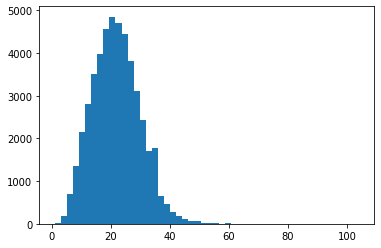

In [12]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show();

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Build and compile a Bidirectional LSTM model

In [15]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [16]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 3,
    verbose = 1,
#    callbacks = callbacks
)

Epoch 1/3
1080/1080 [==============================] - 86s 80ms/step - loss: 0.1906 - accuracy: 0.9570 - val_loss: 0.0675 - val_accuracy: 0.9806
Epoch 2/3
1080/1080 [==============================] - 85s 79ms/step - loss: 0.0527 - accuracy: 0.9846 - val_loss: 0.0499 - val_accuracy: 0.9849
Epoch 3/3
1080/1080 [==============================] - 83s 77ms/step - loss: 0.0381 - accuracy: 0.9885 - val_loss: 0.0477 - val_accuracy: 0.9855


### Evaluate Named Entity Recognition model

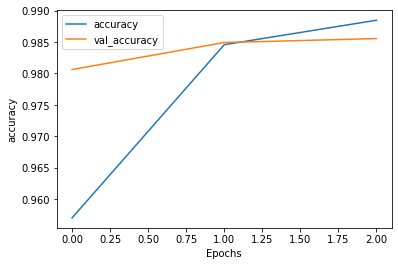

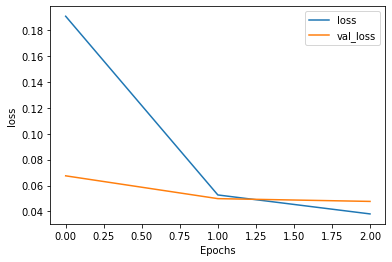

In [25]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [26]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 2s 12ms/step - loss: 0.0503 - accuracy: 0.9851


[0.050299596041440964, 0.9851334691047668]

In [30]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:15}{:5}\t {}\n'.format('Word', 'True', 'Pred'))
print('-'*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{}\t{}'.format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
Two            O	O
Sudanese       B-gpe	B-gpe
rebel          O	O
factions       O	O
joined         O	O
forces         O	O
in             O	O
February       B-tim	B-tim
to             O	O
form           O	O
the            O	O
Eastern        B-org	B-org
Front          I-org	I-org
.              O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O	O
Tachileik      O